# Wine quality prediction

# Imports

In [1]:
import hopsworks
import pandas as pd
import missingno as msno
import numpy as np
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(level='INFO')

mlogger = logging.getLogger('matplotlib')
mlogger.setLevel(logging.WARNING)

## Project setup

In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/197786
Connected. Call `.close()` to terminate connection gracefully.


## Load data

In [3]:
# fetch dataset 
dataset_path = '../dataset/wine/wine.csv'
with open(dataset_path, 'r') as f:
    wine_df = pd.read_csv(f)
wine_df.columns = wine_df.columns.str.replace(' ', '_')
wine_df.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
wine_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed_acidity         6487 non-null   float64
 2   volatile_acidity      6489 non-null   float64
 3   citric_acid           6494 non-null   float64
 4   residual_sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [5]:
wine_df.describe()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


## Preprocessing

### Encode categorical features

In [6]:
# change the type column to binary values 0 and 1 red (0) and white (1)
wine_df['type'] = wine_df['type'].map({'red': 0, 'white': 1})

### Fill missing values

In [7]:
# get each of the missing vlaue indexes for each column
missing_value_indexes = {}
for col in wine_df.columns:
    missing_value_indexes[col] = wine_df[wine_df[col].isnull()].index.tolist()
print('indexes of missing values:')
missing_value_indexes

indexes of missing values:


{'type': [],
 'fixed_acidity': [17, 174, 249, 267, 368, 518, 1079, 2902, 6428, 6429],
 'volatile_acidity': [86, 521, 621, 812, 1079, 2894, 4895, 6486],
 'citric_acid': [268, 909, 6320],
 'residual_sugar': [33, 438],
 'chlorides': [98, 747],
 'free_sulfur_dioxide': [],
 'total_sulfur_dioxide': [],
 'density': [],
 'pH': [54, 139, 440, 587, 697, 972, 4892, 6428, 6429],
 'sulphates': [224, 2902, 6321, 6493],
 'alcohol': [],
 'quality': []}

Replace missing values with a random value from a normal distribution with mean and std of the feature since those features are (more or less) normally distributed according to the histogram plots below

In [8]:
# Replace missing values with a random value from a normal distribution with mean and std of the feature
# Can also use mean for the imputation seems more common when searching online
for col in wine_df.columns:
    mean_val = wine_df[col].mean()
    std_val = wine_df[col].std()
    missing_indexes = wine_df[wine_df[col].isnull()].index.tolist()
    for index in missing_indexes:
        wine_df.loc[index, col] = np.random.normal(mean_val, std_val)

In [9]:
# get each of the missing vlaue indexes for each column
missing_value_indexes = {}
for col in wine_df.columns:
    missing_value_indexes[col] = wine_df[wine_df[col].isnull()].index.tolist()
print('indexes of missing values:')
missing_value_indexes

indexes of missing values:


{'type': [],
 'fixed_acidity': [],
 'volatile_acidity': [],
 'citric_acid': [],
 'residual_sugar': [],
 'chlorides': [],
 'free_sulfur_dioxide': [],
 'total_sulfur_dioxide': [],
 'density': [],
 'pH': [],
 'sulphates': [],
 'alcohol': [],
 'quality': []}

### Balance the data

In [10]:
target = 'quality'
qualities = wine_df[target]
original_shape = wine_df.shape


print(f'original dataset shape {original_shape}')
print('-------------------')
print(f'Original dataset distribution {qualities.value_counts()}')



original dataset shape (6497, 13)
-------------------
Original dataset distribution quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64


In [11]:
wine_df['quality'] = wine_df['quality'].apply(lambda x: 1 if x > 5 else 0)

### Remove duplicate rows

In [12]:
# remove duplicates
count_rows_before = wine_df.shape[0]
wine_df = wine_df.drop_duplicates()
count_rows_after = wine_df.shape[0]

print(f'Number of rows before removing duplicates {count_rows_before}')
print(f'Number of rows after removing duplicates {count_rows_after}')

Number of rows before removing duplicates 6497
Number of rows after removing duplicates 5329


## Exploratory Data Analysis (EDA)


### Univariate analysis

array([[<Axes: title={'center': 'type'}>,
        <Axes: title={'center': 'fixed_acidity'}>,
        <Axes: title={'center': 'volatile_acidity'}>,
        <Axes: title={'center': 'citric_acid'}>],
       [<Axes: title={'center': 'residual_sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free_sulfur_dioxide'}>,
        <Axes: title={'center': 'total_sulfur_dioxide'}>],
       [<Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>,
        <Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>],
       [<Axes: title={'center': 'quality'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

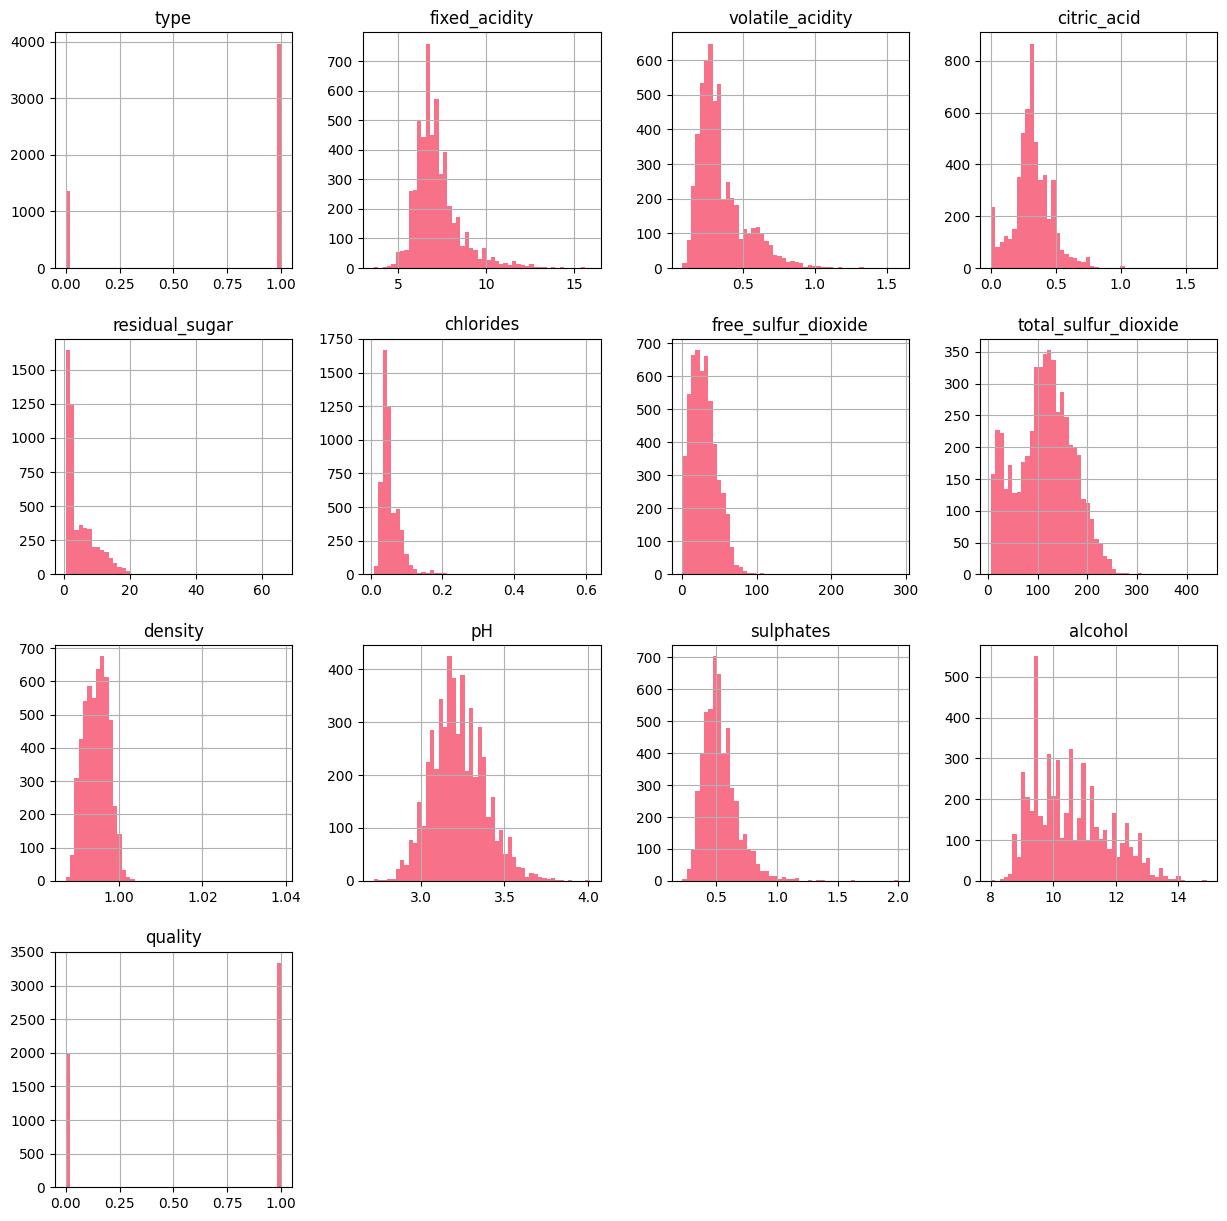

In [13]:
wine_df.hist(figsize=(15, 15), bins=50)

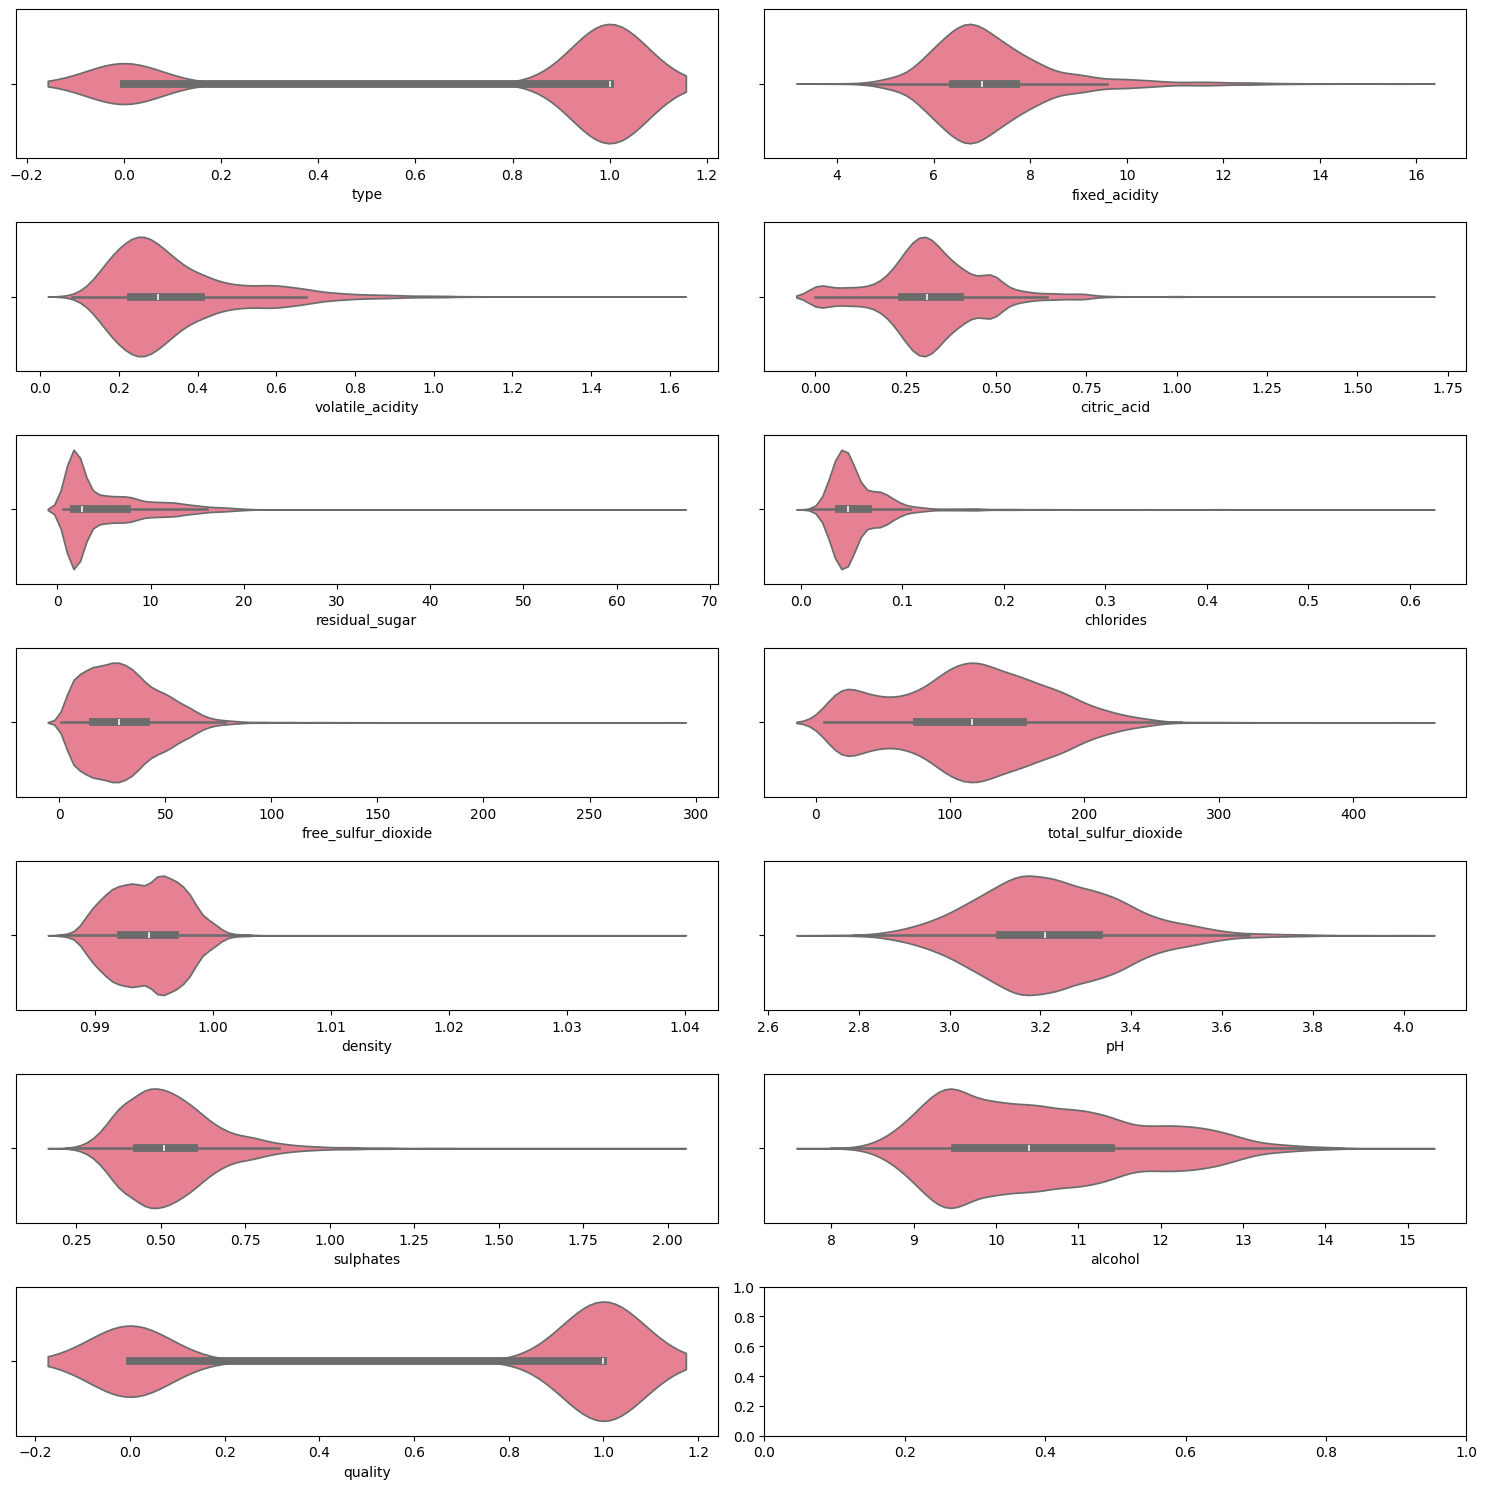

In [14]:
# violin plots using seaborn for the range of values for each feature in seperate plots
fig, axes = plt.subplots(7, 2, figsize=(15, 15))

axes = axes.flatten()
for i, col in enumerate(wine_df.columns):
    sns.violinplot(x=col, data=wine_df, ax=axes[i])

plt.tight_layout()
plt.show()


### Bivariate analysis

{'type_1': [0, 1], 'type_0': [0, 1], 'fixed_acidity_1': [3.629022384103527, 15.6], 'fixed_acidity_0': [4.2, 15.9], 'volatile_acidity_1': [0.08, 1.04], 'volatile_acidity_0': [0.1, 1.58], 'citric_acid_1': [0.0, 1.66], 'citric_acid_0': [0.0, 1.0], 'residual_sugar_1': [0.7, 65.8], 'residual_sugar_0': [0.6, 23.5], 'chlorides_1': [0.012, 0.415], 'chlorides_0': [0.009, 0.611], 'free_sulfur_dioxide_1': [1.0, 112.0], 'free_sulfur_dioxide_0': [2.0, 289.0], 'total_sulfur_dioxide_1': [6.0, 294.0], 'total_sulfur_dioxide_0': [6.0, 440.0], 'density_1': [0.98711, 1.03898], 'density_0': [0.98722, 1.00315], 'pH_1': [2.72, 4.01], 'pH_0': [2.74, 3.9], 'sulphates_1': [0.22, 1.95], 'sulphates_0': [0.25, 2.0], 'alcohol_1': [8.4, 14.2], 'alcohol_0': [8.0, 14.9]}


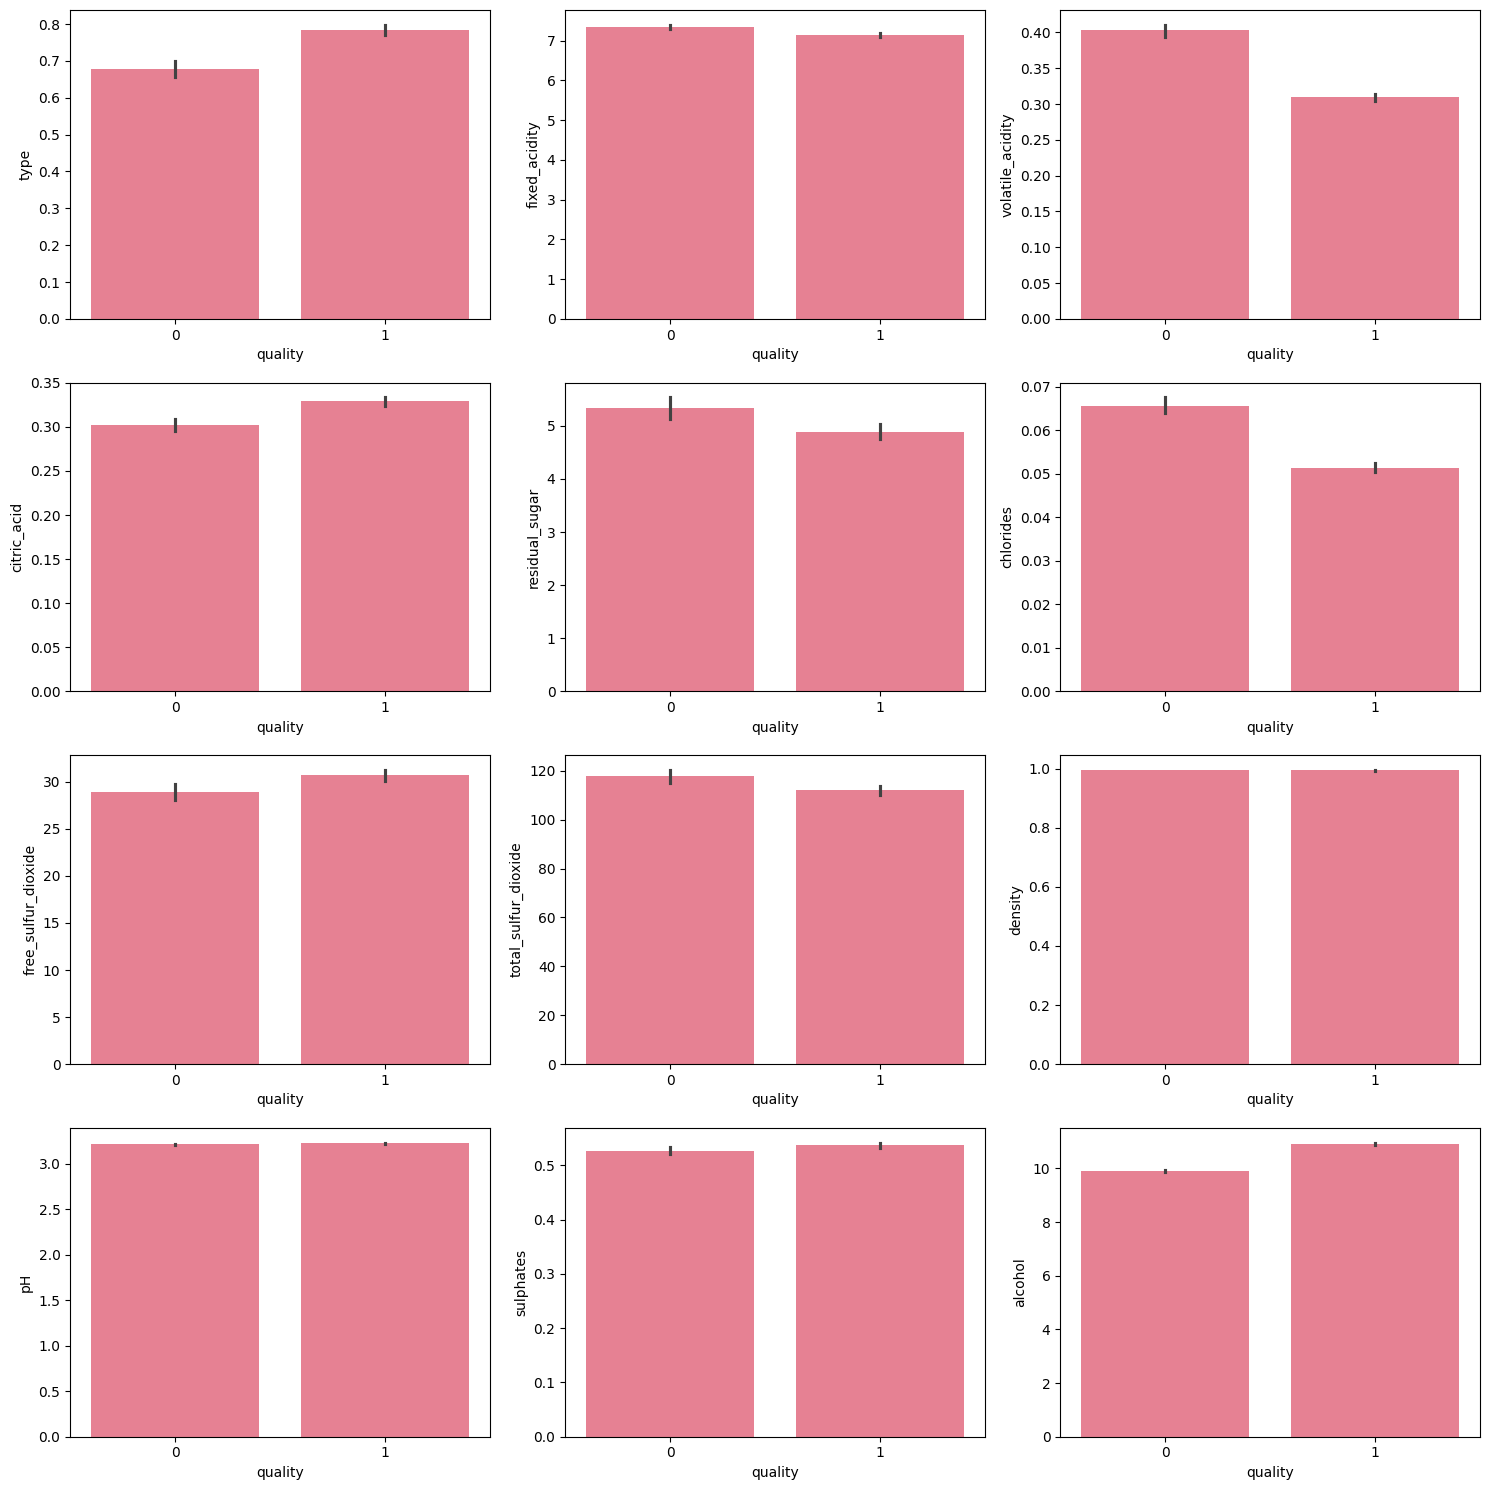

In [15]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

feature_ranges = {}
for i, col in enumerate(wine_df.columns):
    
    if col != 'quality':
        for qualities in wine_df['quality'].unique():
            feature_ranges[col + '_' + str(qualities)] = [wine_df[wine_df['quality'] == qualities][col].min(), wine_df[wine_df['quality'] == qualities][col].max()]
            
        sns.barplot(x='quality', y=col, data=wine_df, ax=axs[i//3, i%3])
# remove the empty plot
print(feature_ranges)
#fig.delaxes(axs[3, 2])
plt.tight_layout()
plt.show()

### Multivariate analysis

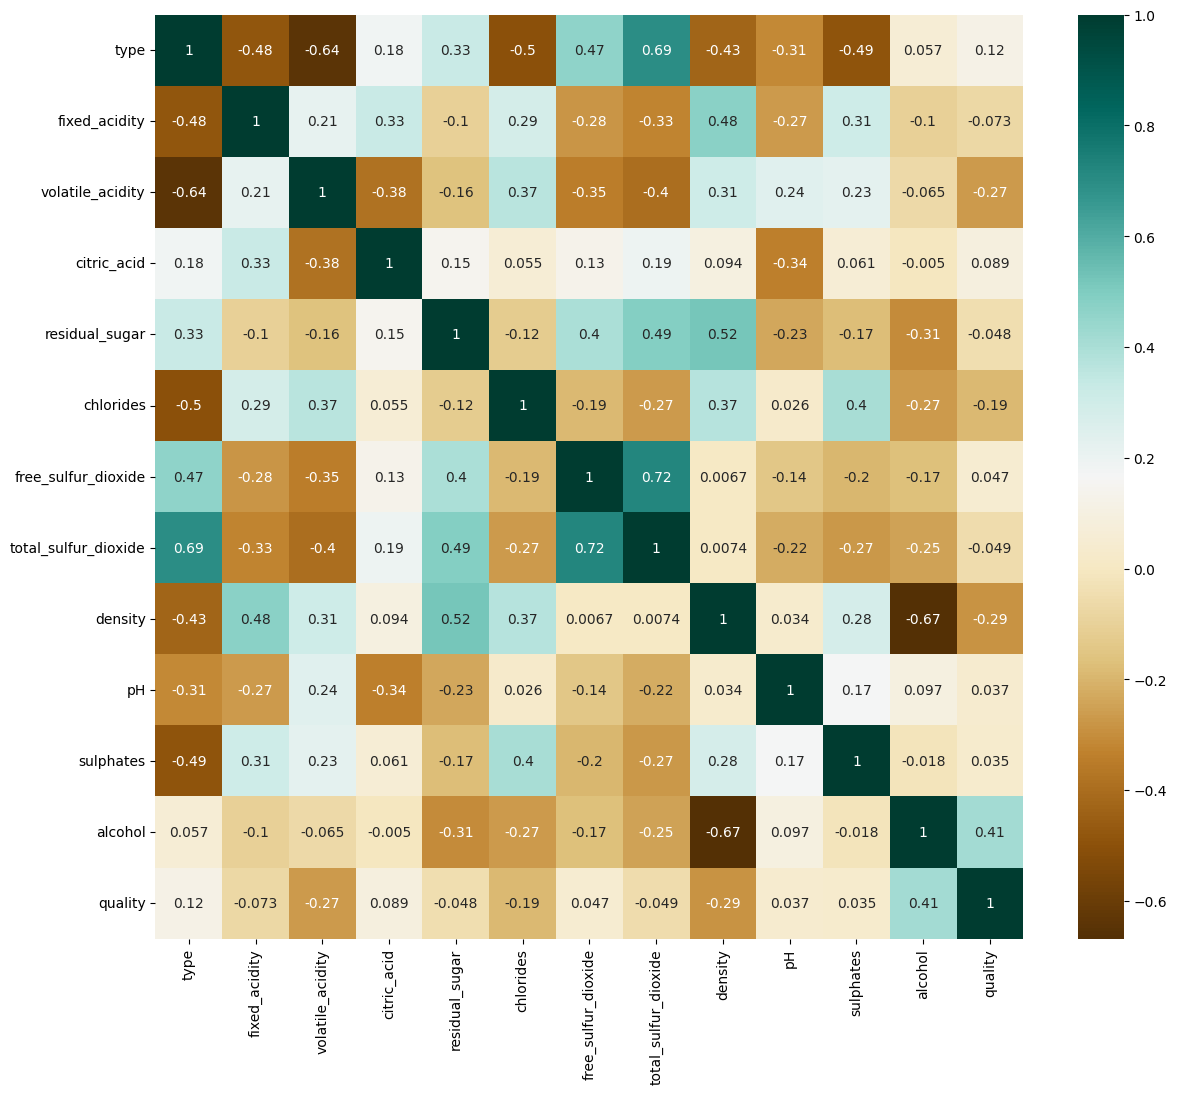

In [16]:
correlation = wine_df.corr()
sns.heatmap(correlation, annot=True, cmap='BrBG').figure.set_size_inches(14, 12)


From the correlation matrix we chose Alchohol, density, chlorides and volatile acidity because they had a high correaltion with the quality. Type was dropped because it has a high correlation with the other features so it does not bring any new information. Free sulfur dioxide and total sulfur dioxide are very highly correlated with eachother so the one with lower correlation to quality(free sulfur dioxide) was dropped,  while we kept total sulfur dioxide. pH and fixed acidity and residual sugar was dropped for similar reasons of having low predictive power. Citric acid was kept because it does not have a high correlation to most of the other features being used so it is possible that it brings some new information. 

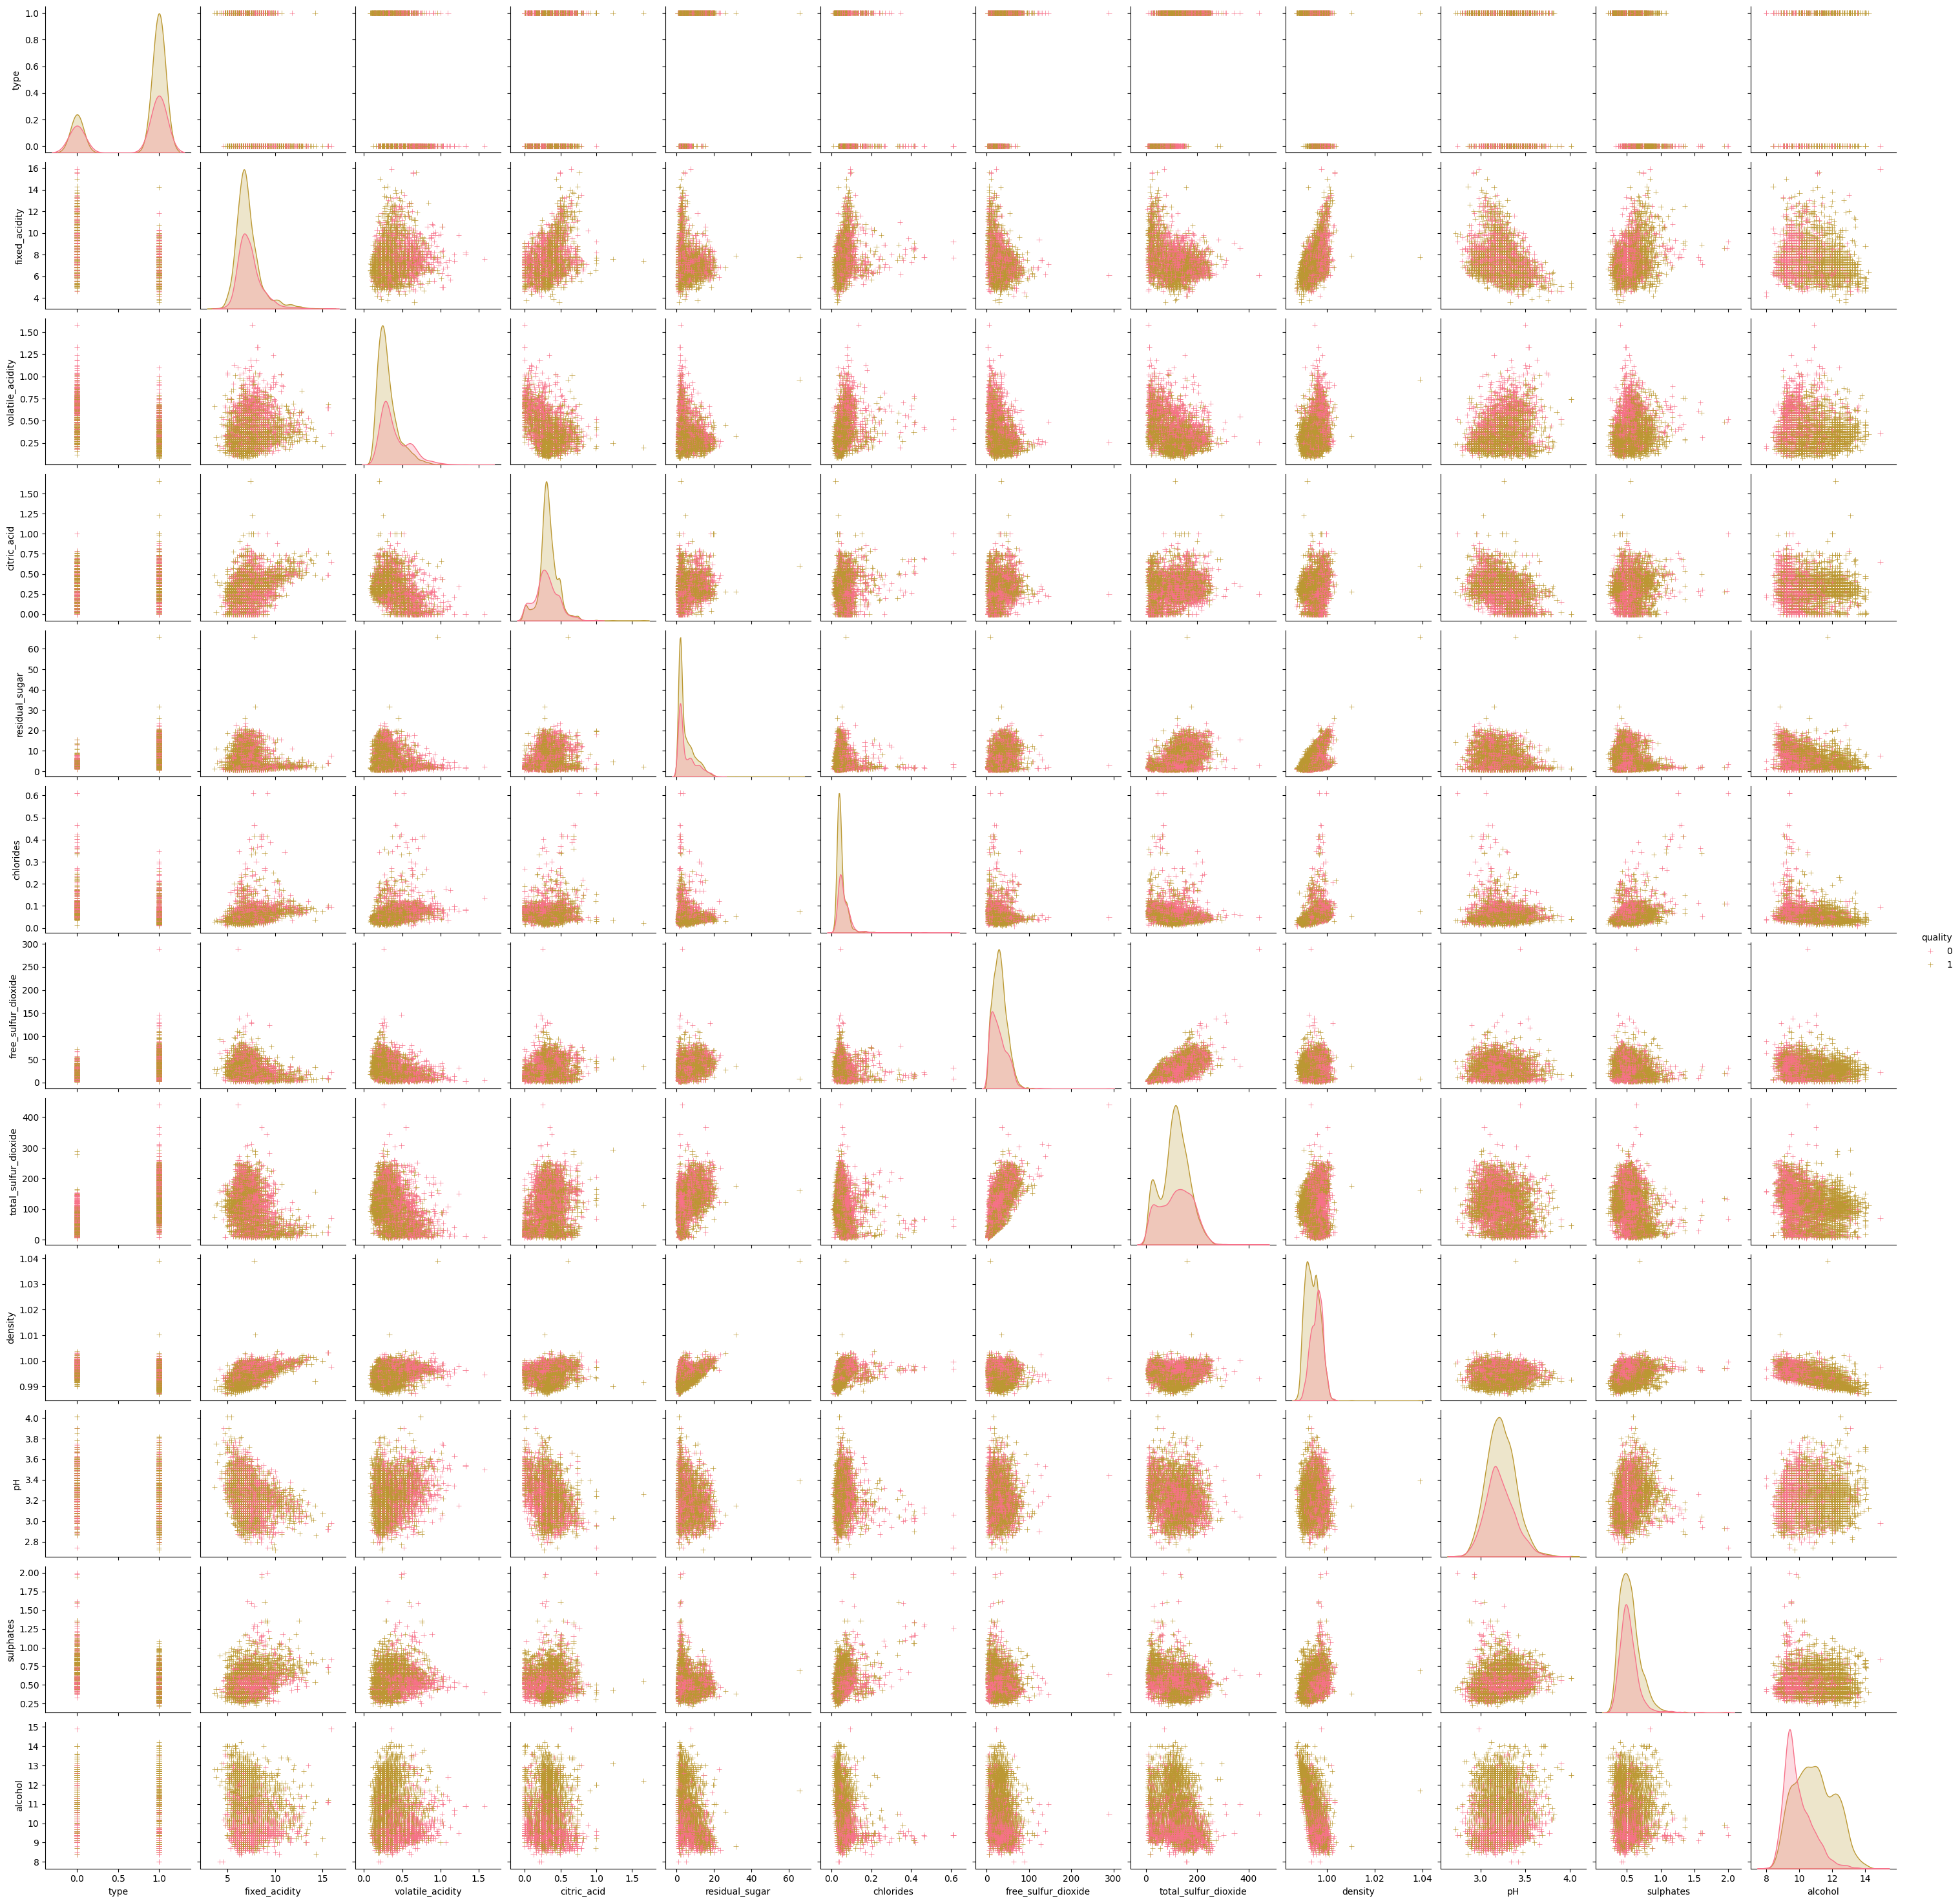

In [17]:
g = sns.pairplot(wine_df, hue='quality', markers='+')
plt.show()

### Feature selection

In [18]:
# List of columns to be dropped
columns_to_drop = ['type','fixed_acidity','residual_sugar','free_sulfur_dioxide','pH','sulphates']
#columns_to_drop = ['fixed_acidity', 'citric_acid', 'residual_sugar', 'total_sulfur_dioxide','free_sulfur_dioxide','pH','sulphates']

wine_df1=wine_df.drop(columns=columns_to_drop)

wine_df1

,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density,alcohol,quality
0,0.270,0.36,0.045,170.0,1.00100,8.8,1
1,0.300,0.34,0.049,132.0,0.99400,9.5,1
2,0.280,0.40,0.050,97.0,0.99510,10.1,1
3,0.230,0.32,0.058,186.0,0.99560,9.9,1
6,0.320,0.16,0.045,136.0,0.99490,9.6,1
...,...,...,...,...,...,...,...
6491,0.620,0.08,0.068,38.0,0.99651,9.5,1
6492,0.600,0.08,0.090,44.0,0.99490,10.5,0
6493,0.550,0.10,0.062,51.0,0.99512,11.2,1
6495,0.645,0.12,0.075,44.0,0.99547,10.2,0


In [19]:
# remove duplicates
count_rows_before = wine_df1.shape[0]
wine_df1 = wine_df1.drop_duplicates()
count_rows_after = wine_df1.shape[0]

print(f'Number of rows before removing duplicates {count_rows_before}')
print(f'Number of rows after removing duplicates {count_rows_after}')

Number of rows before removing duplicates 5329
Number of rows after removing duplicates 5295


In [ ]:


target_column = 'quality'
features = wine_df1.drop(columns=[target_column])
target = wine_df1[target_column]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=20,random_state=1)  # You can adjust parameters here

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict labels for the test set
predicted_labels = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
report = classification_report(y_test, predicted_labels)
print("Classification Report:")
print(report)

### Insert our Wine DataFrame into a FeatureGroup


In [21]:
wine_fg = fs.get_or_create_feature_group(
     name="wine_final",
     version=1,
     primary_key=["volatile_acidity","citric_acid","chlorides",'total_sulfur_dioxide',"density","alcohol"], 
     description="wine dataset")
wine_fg.insert(wine_df1)

Uploading Dataframe: 0.00% |          | Rows 0/5295 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: wine_final_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/197786/jobs/named/wine_final_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fa712d3b5e0>, None)

### Data Validation
If you want, you can enable data validation for your feature group.
The code below will prevent iris flower data from being written your your feature group if you write values outside the expected ranges.

In [22]:
# from great_expectations.core import ExpectationSuite, ExpectationConfiguration

# def expect(suite, column, min_val, max_val):
#     suite.add_expectation(
#     ExpectationConfiguration(
#         expectation_type="expect_column_values_to_be_between",
#         kwargs={
#             "column":column, 
#             "min_value":min_val,
#             "max_value":max_val,
#         }
#     )
# )

In [23]:
# suite = ExpectationSuite(expectation_suite_name="iris_dimensions")

# expect(suite, "sepal_length", 4.5, 8.0)
# expect(suite, "sepal_width", 2.1, 4.5)
# expect(suite, "petal_length", 1.2, 7)
# expect(suite, "petal_width", 0.2, 2.5)
# iris_fg.save_expectation_suite(expectation_suite=suite, validation_ingestion_policy="STRICT")    